Copyright (C) 2023 by The RAND Corporation  
See LICENSE and README.md for information on usage and licensing  

# Karzas-Latter-Seiler Model of EMP

This notebook implements the Seiler model, which is a simplified form of the well-known Karzas-Latter treatment of the Electromagnetic Pulse (EMP) phenomena. The original reference is:

    Seiler Jr, Louis W. A calculational model for high altitude EMP. AIR FORCE INST OF TECH WRIGHT-PATTERSON AFB OH SCHOOL OF ENGINEERING, 1975.
    
- The Seiler report is publicly available through DTIC: [link](https://apps.dtic.mil/sti/pdfs/ADA009208.pdf)
- The published KL report is available here: [link](https://journals.aps.org/pr/abstract/10.1103/PhysRev.137.B1369) behind a paywall
- A publicly-avaiable draft version of the KL report is also available through DTIC: [link](https://apps.dtic.mil/sti/pdfs/AD0607788.pdf)

In [1]:
## imports
import os
from tqdm import tqdm
import pickle 
import numpy as np
import folium
from folium import Map
from folium.plugins import HeatMap
import branca
import pandas as pd
import geojsoncontour
import io
from PIL import Image
import scipy
from scipy.interpolate import CubicSpline
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
import matplotlib 
from cycler import cycler
from constants import * 
import geometry
import emp
import region_scan


## plot settings
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['lines.linewidth'] = 2
plt.rc('font', family='serif',size=16)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])
matplotlib.rcParams.update({"axes.grid":True,
                            "grid.alpha":0.75,
                            "grid.linewidth":0.5})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## PRNG seed
rng = np.random.default_rng(123)

In [2]:
## create a figures folder
if not os.path.exists('figures'):
    os.makedirs('figures')

## create a data folder
if not os.path.exists('data'):
    os.makedirs('data')

## The Model

In [3]:
model = emp.EMPMODEL()

Inspect the many functions that enter into the model.

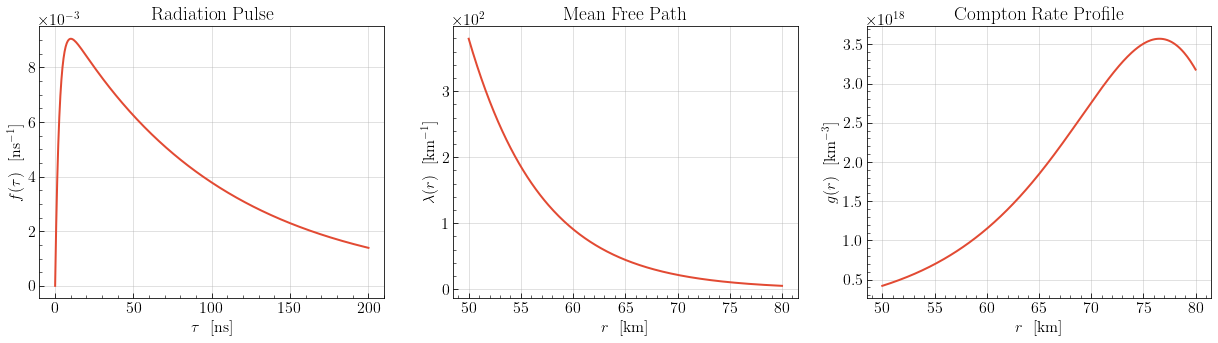

In [4]:
t_list = np.linspace(0, 200, 300)
r_list = np.linspace(model.rmin, model.rmax, 300)

fig, ax = plt.subplots(1, 3, figsize=(3*7,5))

ax[0].set_title('Radiation Pulse')
ax[0].plot(t_list, model.f_pulse(t_list))
ax[0].set_xlabel(r'$\tau$ \ [ns]')
ax[0].set_ylabel(r'$f(\tau)$ \ [ns$^{-1}$]')
ax[0].minorticks_on()
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[1].set_title('Mean Free Path')
ax[1].plot(r_list, model.mean_free_path(r_list))
ax[1].set_xlabel(r'$r$ \ [km]')
ax[1].set_ylabel(r'$\lambda(r)$ \ [km$^{-1}$]')
ax[1].minorticks_on()
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[2].set_title('Compton Rate Profile')
ax[2].plot(r_list, model.gCompton(r_list))
ax[2].set_xlabel(r'$r$ \ [km]')
ax[2].set_ylabel(r'$g(r)$ \ [km$^{-3}$]')
ax[2].minorticks_on()
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('figures/MFP_and_ComptonRate.pdf', bbox_inches='tight')
plt.show()

Next, solve the model for a single line-of-sight integration and compare with the digitized results from Seiler.
- Ideally, the model output would agree with the HAEMP data. There are a few implementation details that were not clear from the Seiler report; perhaps these could be the source of the discrepancy. These include the Compton lifetime $T$, stopping distance $R$, and the electron collision frequency.

In [5]:
HOB = 100
phi_B_g = 39.05 * np.pi/180 #latitude (radians)
lambd_B_g = -95.675 * np.pi/180 #longitude (radians)
Burst_Point = geometry.Point(EARTH_RADIUS + HOB, phi_B_g, lambd_B_g, coordsys='lat/long geo')
Target_Point = geometry.Point(EARTH_RADIUS + HOB, 0.9*phi_B_g, 1.1*lambd_B_g, coordsys='lat/long geo')

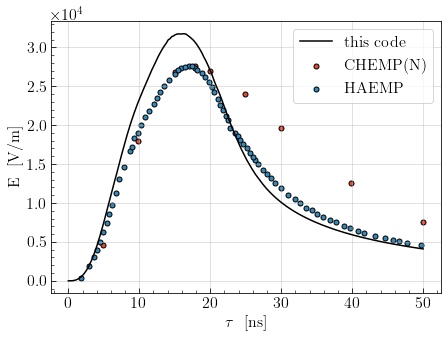

In [6]:
## agreement can be improved by changing r value for E(r) input to nu calculator
model = emp.EMPMODEL(Bnorm=3e-5, Compton_KE=0.75)
sol = model.solver(np.linspace(0, 50, 200))

## load the digitized data from Seiler
df_CHEMP = pd.read_csv("Seiler Digitized Data/Fig5_CHEMP(N).csv", header=None, names=['t', 'E'])
df_HAEMP = pd.read_csv("Seiler Digitized Data/Fig5_HAEMP.csv", header=None, names=['t', 'E'])

## plot
fig, ax = plt.subplots(1, figsize=(7,5))
ax.plot(sol['tlist'], sol['E_norm_at_ground'], '-', color='k', label='this code', linewidth=1.5, markersize=2)
ax.scatter(df_CHEMP['t'], df_CHEMP['E'], label='CHEMP(N)', s=25, edgecolor='k')
ax.scatter(df_HAEMP['t'], df_HAEMP['E'], label='HAEMP', s=25, edgecolor='k')
ax.set_xlabel(r'$\tau$ \ [ns]')
ax.set_ylabel('E \ [V/m]')
ax.legend()
ax.minorticks_on()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('figures/seiler_comparison.pdf', bbox_inches='tight')
plt.show()

Add the $\gamma$-ray pulse to the plot to compare the time-dependence of the $\gamma$-rays and the EMP.

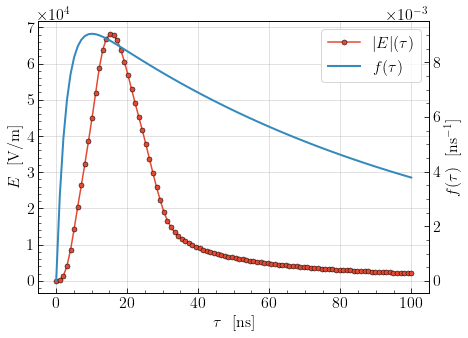

In [7]:
model = emp.EMPMODEL()
sol = model.solver(np.linspace(0, 100, 100))

## plot
fig, ax = plt.subplots(1, figsize=(7,5))
ax2 = ax.twinx()
#ax.grid(color='k')
#ax.grid(False)#, color=colors[0])
ax2.grid(False)#, color=colors[1])

lns0 = ax.plot(
    sol['tlist'], 
    sol['E_norm_at_ground'], 
    '-o',
    label=r'$|E|(\tau)$', 
    color=colors[0],
    linewidth=1.5,
    markersize=5,
    markerfacecolor=colors[0],
    markeredgecolor='k',
    markeredgewidth=0.5
    )

lns1 = ax2.plot(sol['tlist'], model.f_pulse(sol['tlist']), label=r'$f(\tau)$', color=colors[1], linestyle='-')

lns = lns0 + lns1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_xlabel(r'$\tau$ \ [ns]')
ax.set_ylabel(r'$E$ \ [V/m]')#, color=colors[0])
ax2.set_ylabel(r'$f(\tau)$ \ [ns$^{-1}$]')#, color=colors[1])

ax.minorticks_on()
ax2.minorticks_on()

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('figures/EMP_and_gamma_pulse.pdf', bbox_inches='tight')
plt.show()

Investigate the effect of changing latitude.

In [8]:
b_field_type = 'dipole'

## burst coordinates 
HOB = 100
phi_B_g = 39.05 * np.pi/180 #latitude (radians)
lambd_B_g = -95.675 * np.pi/180 #longitude (radians)
Burst_Point = geometry.Point(EARTH_RADIUS + HOB, phi_B_g, lambd_B_g, coordsys='lat/long geo')
t_list = np.linspace(0, 100, 200)

## target latitudes
N_pts_phi = 200 #number of latitude grid points
Delta_angle = geometry.compute_max_delta_angle_1d(Burst_Point)
phi_T_g_list = phi_B_g + np.linspace(-Delta_angle/2, Delta_angle/2, N_pts_phi)

## scan over target locations
data_dic = {'phi_T_g':[], 
            'phi_T_m':[], 
            'A':[], 
            'theta':[], 
            'Bnorm':[],
            'sol':[]
            }

for i in tqdm(range(len(phi_T_g_list))):

    ## update target coords
    phi_T_g = phi_T_g_list[i]
    lambd_T_g = lambd_B_g
    Target_Point = geometry.Point(EARTH_RADIUS, phi_T_g, lambd_T_g, coordsys='lat/long geo')

    ## get B-field evaluation point
    Midway_Point = geometry.get_line_of_sight_midway_point(Burst_Point, Target_Point)    
    
    ## build and solve the model
    model = emp.EMPMODEL(
        HOB=HOB,
        A = geometry.get_A(Burst_Point, Midway_Point),
        theta = geometry.get_theta(Burst_Point, Midway_Point, b_field_type=b_field_type),
        Bnorm = geometry.get_geomagnetic_field_norm(Midway_Point, b_field_type=b_field_type)
    )
    sol = model.solver(t_list)

    ## store results
    data_dic['phi_T_g'].append(phi_T_g)
    data_dic['A'].append(geometry.get_A(Burst_Point, Midway_Point))
    data_dic['theta'].append(model.theta)
    data_dic['Bnorm'].append(model.Bnorm)
    data_dic['sol'].append(sol)

100%|██████████| 200/200 [22:22<00:00,  6.71s/it]


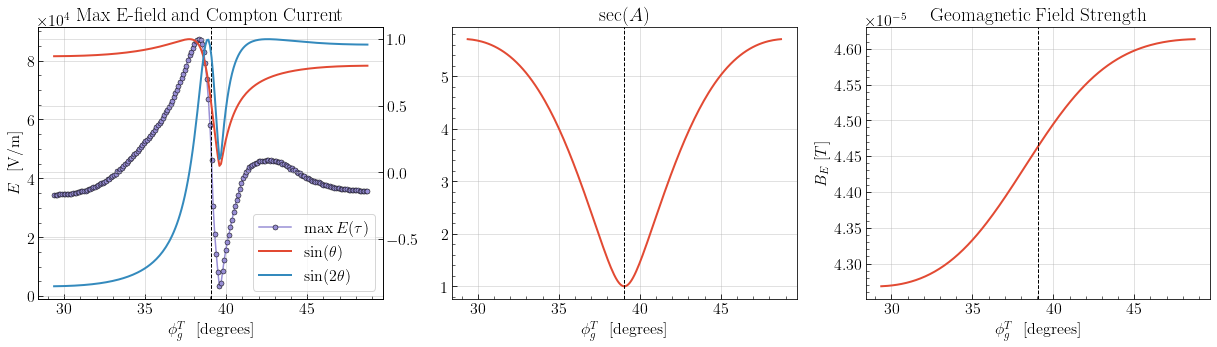

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(3*7,5))

ax[0].set_title('Max E-field and Compton Current')
ax2 = ax[0].twinx()
max_E = np.asarray([np.max(data_dic['sol'][i]['E_norm_at_ground']) for i in range(len(data_dic['sol']))])
lns_E = ax[0].plot(
    180/np.pi * np.asarray(data_dic['phi_T_g']), 
    max_E, 
    '-o', 
    label=r'$\max E(\tau)$', 
    color=colors[2],
    linewidth=1.5,
    markersize=5,
    markerfacecolor=colors[2],
    markeredgecolor='k',
    markeredgewidth=0.5
)            
lns_sin = ax2.plot(180/np.pi * np.asarray(data_dic['phi_T_g']), np.sin(np.asarray(data_dic['theta'])), 
               '-', label=r'$\sin(\theta)$')
lns_sin2 = ax2.plot(180/np.pi * np.asarray(data_dic['phi_T_g']), np.sin(2*np.asarray(data_dic['theta'])), 
               '-', label=r'$\sin(2\theta)$')
lns = lns_E + lns_sin + lns_sin2
labs = [l.get_label() for l in lns]
ax[0].set_ylabel(r'$E$ \ [V/m]')
ax[0].legend(lns, labs, loc='lower right')
ax[0].set_xlabel(r'$\phi_g^T$ \ [degrees]')
ax[0].minorticks_on()
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].axvline(x=180/np.pi * phi_B_g, color='k', linestyle='--', linewidth=1)

ax[1].set_title(r'sec$(A)$')
ax[1].plot(180/np.pi * np.asarray(data_dic['phi_T_g']), 1/np.cos(np.asarray(data_dic['A'])))
ax[1].set_xlabel(r'$\phi_g^T$ \ [degrees]')
ax[1].minorticks_on()
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].axvline(x=180/np.pi * phi_B_g, color='k', linestyle='--', linewidth=1)

ax[2].set_title('Geomagnetic Field Strength')
ax[2].plot(180/np.pi * np.asarray(data_dic['phi_T_g']), np.asarray(data_dic['Bnorm']))
ax[2].set_xlabel(r'$\phi_g^T$ \ [degrees]')
ax[2].set_ylabel(r' $B_E \ [T]$')
ax[2].minorticks_on()
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[2].axvline(x=180/np.pi * phi_B_g, color='k', linestyle='--', linewidth=1)

#[ax[i].set_xlim([36, 43]) for i in range(3)]

plt.savefig('figures/angle_variation_with_latitude.pdf', bbox_inches='tight')
plt.show()

Lastly, plot the source terms for both the Seiler and KL methods.

In [10]:
## instantiate an EMP model object
model = emp.EMPMODEL(theta=np.pi/4)

## scan over a range of times and calculate each current and conductivity (both Seiler and KL methods)
t_list = np.exp(np.linspace(np.log(1), np.log(1000), 400))

conductivity_list = [model.conductivity((model.rmin + model.rmax)/2, t, 4e3) for t in t_list]
conductivity_KL_list = [model.conductivity_KL((model.rmin + model.rmax)/2, t, 4e3) for t in t_list]

J_theta_list = [model.JCompton_theta((model.rmin + model.rmax)/2, t) for t in t_list]
J_phi_list = [model.JCompton_phi((model.rmin + model.rmax)/2, t) for t in t_list]

J_theta_KL_list = [model.JCompton_theta_KL((model.rmin + model.rmax)/2, t) for t in t_list]
J_phi_KL_list = [model.JCompton_phi_KL((model.rmin + model.rmax)/2, t) for t in t_list]

/Users/hartnett/Desktop/EMP/karzas-latter-seiler/emp.py:514: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  outer_integral = quad( lambda tau: inner_integral(tau), 0.0, t )[0]


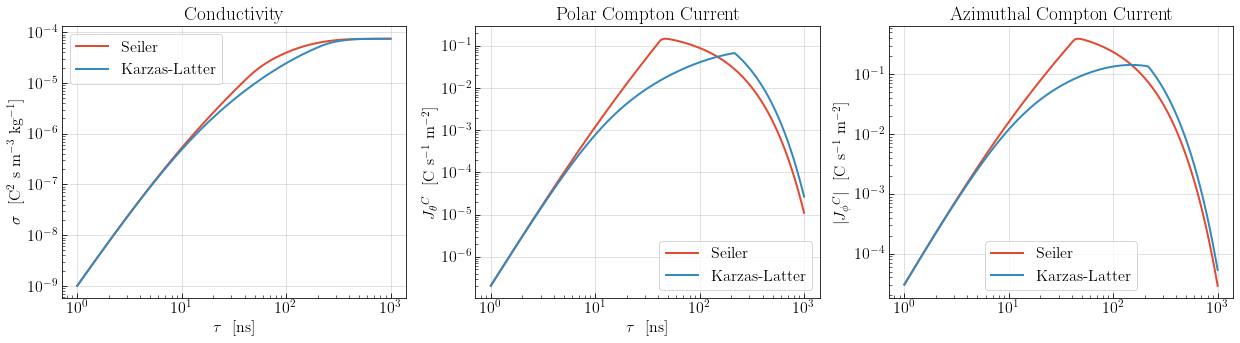

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(3*7,5))

ax[0].set_title(r'Conductivity')
ax[0].plot(t_list, conductivity_list, label='Seiler')
ax[0].plot(t_list, conductivity_KL_list, label='Karzas-Latter')
ax[0].set_xlabel(r'$\tau$ \ [ns]')
ax[0].set_ylabel(r'$\sigma$ \ [C$^2$ s m$^{-3}$ kg$^{-1}$]')
ax[0].minorticks_on()
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_title(r'Polar Compton Current')
ax[1].plot(t_list, J_theta_list, label='Seiler')
ax[1].plot(t_list, J_theta_KL_list, label='Karzas-Latter')
ax[1].set_xlabel(r'$\tau$ \ [ns]')
ax[1].set_ylabel(r'$J_{\theta}{}^C$ \ [C s$^{-1}$ m$^{-2}$]')
ax[1].minorticks_on()
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[2].set_title(r'Azimuthal Compton Current')
ax[2].plot(t_list, np.abs(J_phi_list), label='Seiler')
ax[2].plot(t_list, np.abs(J_phi_KL_list), label='Karzas-Latter')
ax[2].set_ylabel(r'$|J_{\phi}{}^C|$ \ [C s$^{-1}$ m$^{-2}$]')
ax[2].minorticks_on()
ax[2].legend()
ax[2].set_xscale('log')
ax[2].set_yscale('log')

plt.savefig('figures/Seiler_vs_KL.pdf', bbox_inches='tight')

plt.show()

The approximation gets bad after around 20 ns. For comparison, evaluate the characteristic time-scale set by $\omega$, and also $\omega T$:

In [12]:
print('1/omega [ns]: %.4f' % (1/(1e-9 * model.omega)))

1/omega [ns]: 641.4038


In [13]:
print(r'omega * T at lower boundary of absorption layer: %.4f' % (1e-9 * model.omega * model.TCompton(model.rmax)))
print(r'omega * T at upper boundary of absorption layer: %.4f' % (1e-9 * model.omega * model.TCompton(model.rmin)))

omega * T at lower boundary of absorption layer: 0.0170
omega * T at upper boundary of absorption layer: 0.0648


## Smile Diagrams

Perform a 2d angular scan over both latitude and longitude for a burst over Kansas.

In [14]:
## burst coordinates
gz_name = 'topeka'
phi_B_g = 39.05 * np.pi/180 #latitude (radians)
lambd_B_g = -95.675 * np.pi/180 #longitude (radians)
HOB = 100
Burst_Point = geometry.Point(EARTH_RADIUS + HOB, phi_B_g, lambd_B_g, coordsys='lat/long geo')

## perform the region scan
data_dic = region_scan.region_scan(
    Burst_Point, 
    N_pts_phi=100,
    N_pts_lambd=100,
    b_field_type='dipole'
    )

## save the result
with open(f'data/{gz_name}s_dic.pkl', 'wb') as f:
    pickle.dump(data_dic, f)

## make a contour plot
#x, y, z = region_scan.data_dic_to_xyz(data_dic)
#contourf = region_scan.contour_plot(x, y, z, save_path=f'figures/{gz_name}_smile_contouronly.pdf', grid=True)
#contourf = region_scan.contour_plot(x, y, z) # remove the grid

100%|██████████| 100/100 [3:33:59<00:00, 128.40s/it]


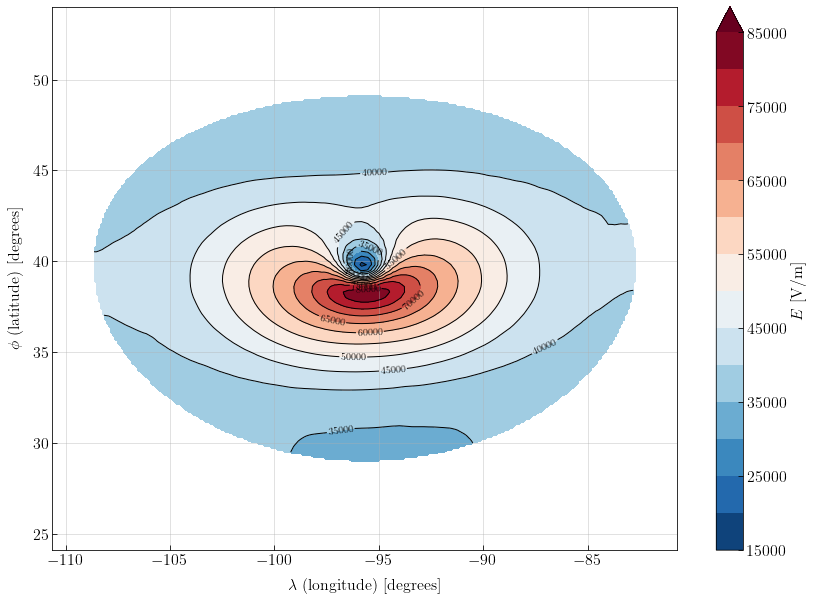

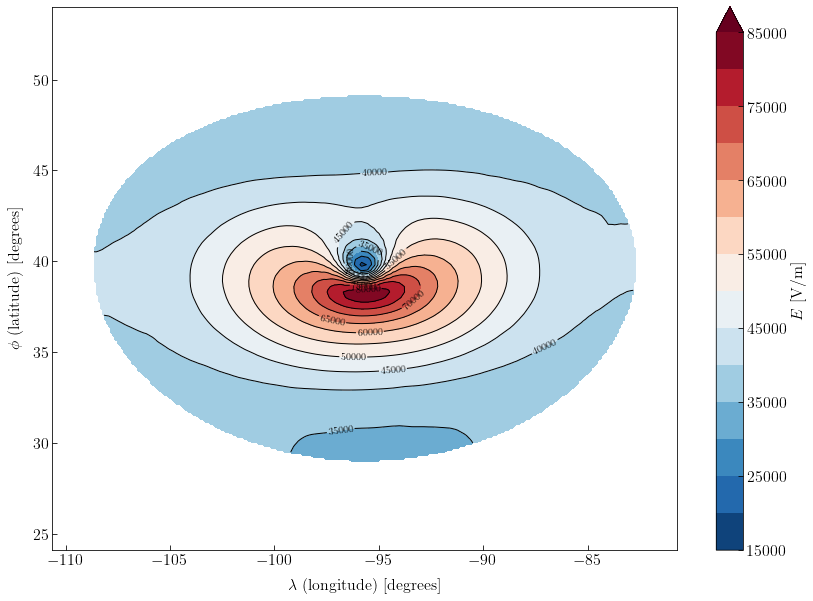

In [15]:
from importlib import reload
reload(region_scan)

## make a contour plot
x, y, z = region_scan.data_dic_to_xyz(data_dic)
contourf, _ = region_scan.contour_plot(x, y, z, Burst_Point, save_path=f'figures/{gz_name}_smile_contouronly.pdf', grid=True)
contourf, levels = region_scan.contour_plot(x, y, z, Burst_Point) # remove the grid

Super-impose this on a map of the Earth

In [16]:
region_scan.folium_plot(
    contourf, 
    Burst_Point.phi_g * 180/np.pi,
    Burst_Point.lambd_g * 180/np.pi,
    levels,
    gz_name
    )

Next, consider a burst point in the Southern hemisphere, for example Sydney, Australia or Cape Town, South Africa.

100%|██████████| 100/100 [3:27:20<00:00, 124.40s/it]


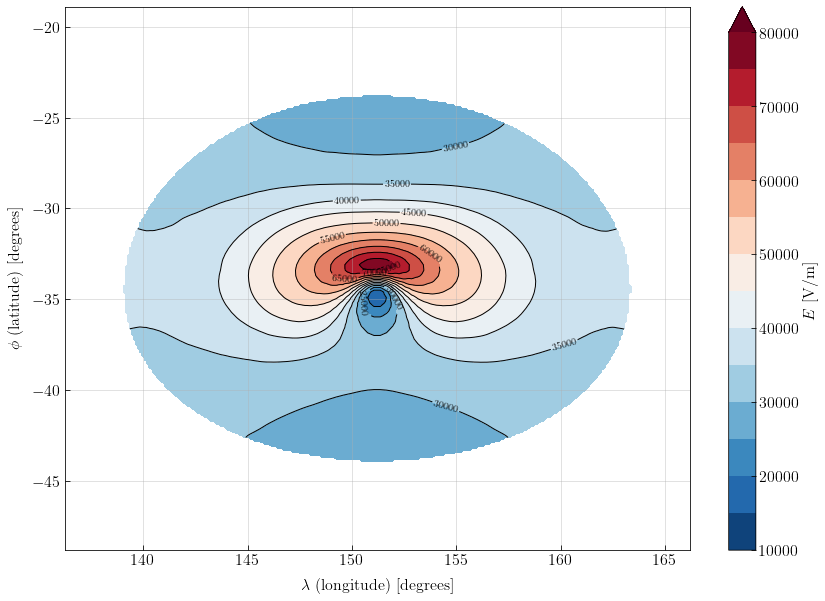

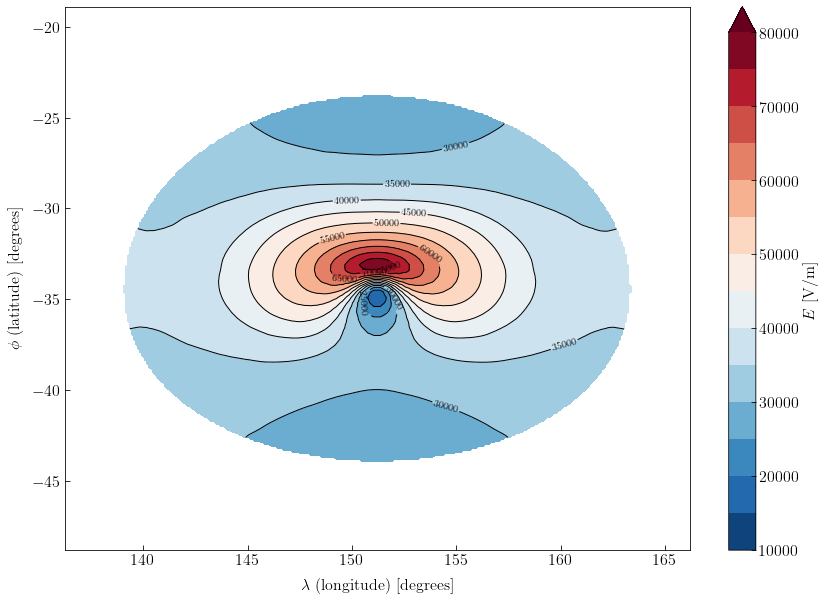

In [17]:
## burst coordinates
gz_name = 'sydney'
phi_B_g = -33.86 * np.pi/180 #latitude (radians)
lambd_B_g = 151.2093 * np.pi/180 #longitude (radians)
HOB = 100
Burst_Point = geometry.Point(EARTH_RADIUS + HOB, phi_B_g, lambd_B_g, coordsys='lat/long geo')

#gz_name = 'capetown'
#phi_B_g = -33.9249 * np.pi/180 #latitude (radians)
#lambd_B_g = 18.4241 * np.pi/180 #longitude (radians)

## perform the region scan
data_dic = region_scan.region_scan(
    Burst_Point, 
    N_pts_phi=100,
    N_pts_lambd=100
    )

## save the result
with open(f'data/{gz_name}s_dic.pkl', 'wb') as f:
    pickle.dump(data_dic, f)
    
## make a contour plot
x, y, z = region_scan.data_dic_to_xyz(data_dic)
contourf, _ = region_scan.contour_plot(x, y, z, Burst_Point, save_path=f'figures/{gz_name}_smile_contouronly.pdf', grid=True)
contourf, levels = region_scan.contour_plot(x, y, z, Burst_Point) # remove the grid

In [18]:
region_scan.folium_plot(
    contourf, 
    Burst_Point.phi_g * 180/np.pi,
    Burst_Point.lambd_g * 180/np.pi,
    levels,
    gz_name
    )

Now make the same plot, but using the IGRF magnetic field.

100%|██████████| 100/100 [3:33:59<00:00, 128.40s/it]


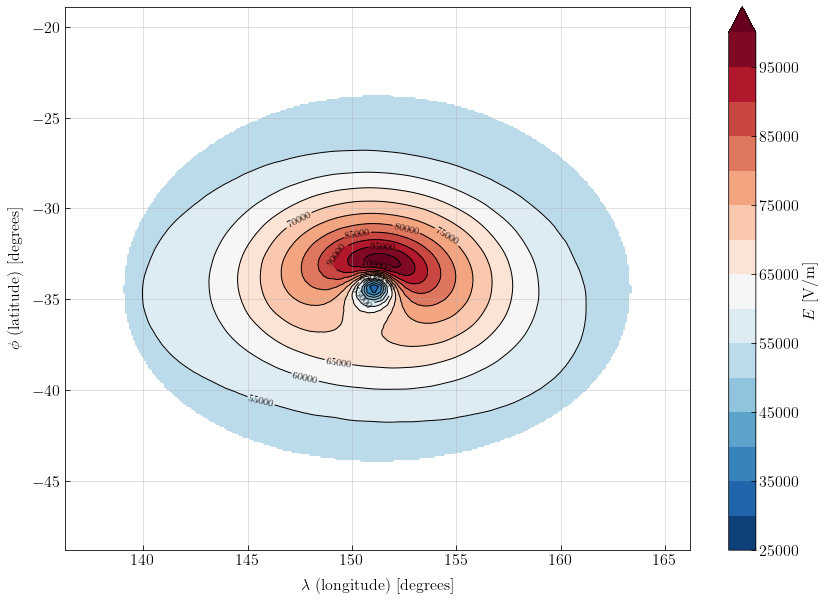

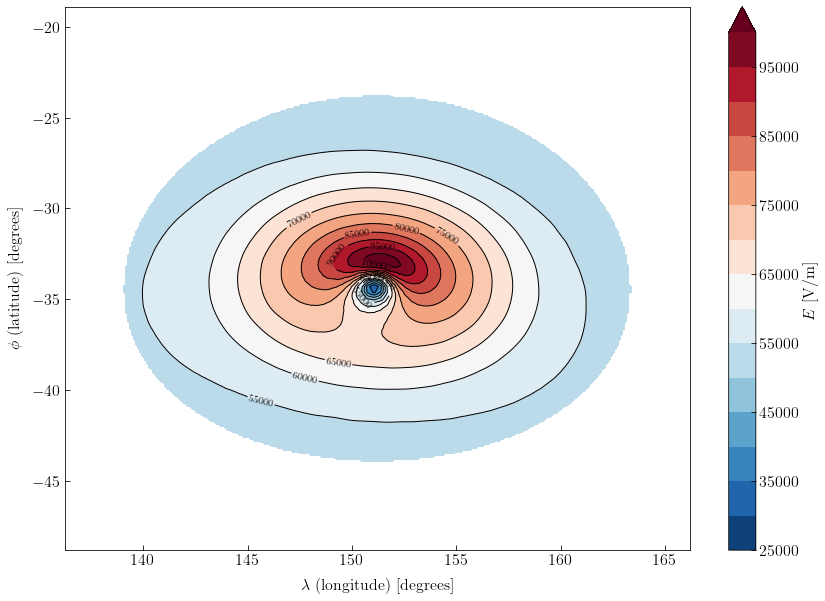

In [19]:
## burst coordinates
gz_name = 'sydney_igrf'
phi_B_g = -33.86 * np.pi/180 #latitude (radians)
lambd_B_g = 151.2093 * np.pi/180 #longitude (radians)
HOB = 100
Burst_Point = geometry.Point(EARTH_RADIUS + HOB, phi_B_g, lambd_B_g, coordsys='lat/long geo')

## perform the region scan
data_dic = region_scan.region_scan(
    Burst_Point, 
    N_pts_phi=100,
    N_pts_lambd=100,
    b_field_type='igrf'
    )

## save the result
with open(f'data/{gz_name}s_dic.pkl', 'wb') as f:
    pickle.dump(data_dic, f)
    
## make a contour plot
x, y, z = region_scan.data_dic_to_xyz(data_dic)
contourf, _ = region_scan.contour_plot(x, y, z, Burst_Point, save_path=f'figures/{gz_name}_smile_contouronly.pdf', grid=True)
contourf, levels = region_scan.contour_plot(x, y, z, Burst_Point) # remove the grid

In [20]:
region_scan.folium_plot(
    contourf, 
    Burst_Point.phi_g * 180/np.pi,
    Burst_Point.lambd_g * 180/np.pi,
    levels,
    gz_name
    )

## Variation of $\sin\theta$ with latitude. 

In [21]:
## set-up
phi_B_m_list = [15*i * np.pi/180 for i in range(1, 6)] # burst latitude grid
N_pts_HOB = 30 # number of heights to consider
HOB_list = np.linspace(55, 400, N_pts_HOB) # HOB grid

phi_min_theta = np.zeros((len(phi_B_m_list), len(HOB_list)))
phi_max_theta = np.zeros((len(phi_B_m_list), len(HOB_list)))
ground_dists_min_theta = np.zeros((len(phi_B_m_list), len(HOB_list)))
ground_dists_max_theta = np.zeros((len(phi_B_m_list), len(HOB_list)))

for i in range(len(phi_B_m_list)):
    for j in range(len(HOB_list)):

        Burst_Point = geometry.Point(EARTH_RADIUS + HOB_list[j], phi_B_m_list[i], 0, 'lat/long mag')
        
        def get_sin_theta_lat(phi_T_m): 
            Target_Point = geometry.Point(EARTH_RADIUS, phi_T_m, 0, 'lat/long mag')
            Midway_Point = geometry.get_line_of_sight_midway_point(Burst_Point, Target_Point)
            return np.sin(geometry.get_theta(Burst_Point, Midway_Point, b_field_type='dipole'))

        #get_sin_theta_lat(11 * np.pi/180)
        Delta_angle = geometry.compute_max_delta_angle_1d(geometry.Point(EARTH_RADIUS + HOB_list[j], phi_B_m_list[i], 0, 'lat/long mag'))

        ## minimization
        result = scipy.optimize.minimize_scalar(get_sin_theta_lat, method='bounded', bounds=(phi_B_m_list[i] - Delta_angle/2, phi_B_m_list[i] + Delta_angle/2))        
        Target_Point = geometry.Point(EARTH_RADIUS, result.x, 0, 'lat/long mag')    
        phi_min_theta[i,j] = np.arcsin(result.fun)
        ground_dists_min_theta[i,j] = geometry.great_circle_distance(Burst_Point, Target_Point)

        ## maximization
        result = scipy.optimize.minimize_scalar(lambda x: -get_sin_theta_lat(x), method='bounded', bounds=(phi_B_m_list[i] - Delta_angle/2, phi_B_m_list[i] + Delta_angle/2))        
        Target_Point = geometry.Point(EARTH_RADIUS, result.x, 0, 'lat/long mag')
        phi_max_theta[i,j] = np.arcsin(result.fun)
        ground_dists_max_theta[i,j] = geometry.great_circle_distance(Burst_Point, Target_Point)

Reproduce Fig 2-11 of  *E. Savage, J. Gilbert, and W. Radasky, The early-time (e1) high-altitude electromagnetic pulse (hemp) and its impact on the us power grid, Report Meta (2010)*:

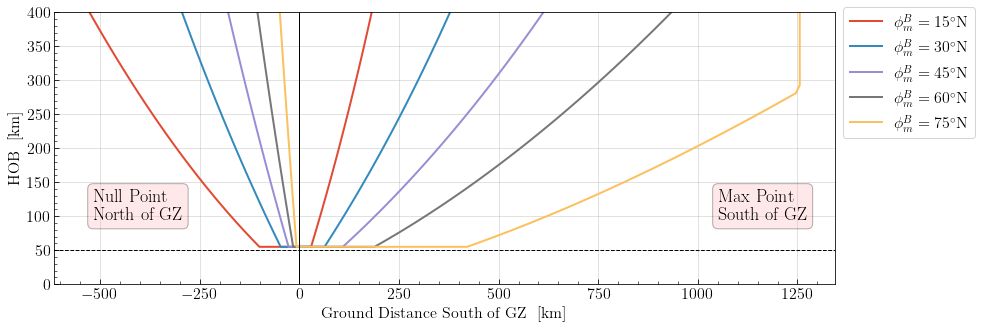

In [22]:
## plot
fig, ax = plt.subplots(figsize=(2*7,5))

for i in range(len(phi_B_m_list)):
    
    ax.plot(
        list(-ground_dists_min_theta[i, ::-1]) + list(ground_dists_max_theta[i,:]), 
        list(HOB_list)[::-1] + list(HOB_list), 
        '-', 
        label=r'$\phi_m^B = %.0f^{\circ}$N' % (180/np.pi * phi_B_m_list[i])
        )

ax.axhline(ABSORPTION_LAYER_UPPER, linestyle='--', linewidth=1, color='k')    
ax.axvline(0, linestyle='-', linewidth=1, color='k')    
ax.legend(bbox_to_anchor=(1., 1.05))
ax.set_xlabel(r'Ground Distance South of GZ \ [km]')
ax.set_ylabel(r'HOB \ [km]')
#ax.set_title(r'Ground Distance to $\sin\theta$ Extremal Points')
ax.set_ylim([0, max(HOB_list)])
ax.minorticks_on()

props = dict(boxstyle='round', facecolor=colors[-1], alpha=0.3, edgecolor='black')
ax.text(0.85, 0.35, 'Max Point\nSouth of GZ', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)
ax.text(0.05, 0.35, 'Null Point\nNorth of GZ', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

plt.savefig('figures/fig_2_11_savage_et_al.pdf', bbox_inches='tight')
plt.show()